# Main Jupyter Notebook

### Problem Statement
How did World War 1 and the Civil War affect commodity prices in America?

I will be looking at data in the Allen-Unger dataseset to see how prices rose and fell in WW1 and the Civil War. The analysis will focus on the state of Vermont, as there is a robust and diverse spread of data.

* By what percentage did a commodity rise during each war compared to the previous average, and by how much did it fall afterwards?
    * I will be comparing the wartime peak and the wartime average.
    * If a commodity stayed stable, is there a historical reason?
    * Do the prices recover to normal after the war?
* Which commodities were most affected be each war?
* How did the effects compare across each war? For example, was cloth more affected by the Civil War or World War 1?
* How volatile was the price before/during/after each war?

Also being taken into consideration is the period directly after the Civil War that includes the Second Industrial Revolution, and the period after the WW1 that includes the Roaring Twenties.

### Commodities Considered
Cloth, Tea, Axes, Flour, Coffee, Bread, Codfish, Sugar


In [1]:
# Library and custom function imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from helper.helper import miss_years

In [2]:
# Helper Functions
def miss_years(df):
    # Returns the missing years in a commodity and location dataframe, or if empty returns str 'none'
    # Assumes years are unique in given df and sorted (ascending)
    df = df.sort_values(by=["Item Year"])
    df_f_l = df["Item Year"].iloc[[0,-1]] # first and last year
    year_s = pd.Series(np.arange(df_f_l.iloc[0], df_f_l.iloc[-1]+1)) # full list from first to last year
    missing = pd.concat([df["Item Year"], year_s]).drop_duplicates(keep=False) # The missing years
    if missing.empty:
        missing = "none"
    else:
        missing = missing.tolist()
    return missing

### Data Exploration

In [3]:
df_raw = pd.read_csv("data_raw/all_commodities.csv")
#df_raw.head()

In [4]:
# Let's make some basic lists and dataframes that will be referenced

com_ls = ['Axe', 'Bread', 'Cloth', 'Codfish', 'Coffee', 'Flour', 'Sugar', 'Tea']

# This dataframe will filter for Vermont and the commodities that will be analyzed
df_v = df_raw[(df_raw["Location"] == "Vermont") & (df_raw["Commodity"].isin(com_ls))]

# Sugar has two varieties, one being a NaN and the other being Maple. Maple data cuts of at 1909, so it will be excluded.
df_v = df_v.drop(df_v[(df_v['Commodity'] == 'Sugar') & (df_v['Variety'] == 'Maple')].index)

In [5]:
# Let's find the min and max years for our commodities, and then see if they have any missing years that will need to be interpolated

print(f"Minimum Year:\n{df_v.groupby(['Commodity'])['Item Year'].min()}\n")
print(f"Maximum Year:\n{df_v.groupby(['Commodity'])['Item Year'].max()}\n")

for x in com_ls:
    yrs = miss_years(df_v[df_v["Commodity"] == x])
    print(f"{x}: {yrs}")

Minimum Year:
Commodity
Axe        1790
Bread      1893
Cloth      1804
Codfish    1790
Coffee     1791
Flour      1828
Sugar      1790
Tea        1790
Name: Item Year, dtype: int64

Maximum Year:
Commodity
Axe        1940
Bread      1940
Cloth      1940
Codfish    1938
Coffee     1940
Flour      1940
Sugar      1940
Tea        1940
Name: Item Year, dtype: int64

Axe: [1791, 1792, 1795, 1797, 1798]
Bread: none
Cloth: none
Codfish: [1797, 1798, 1799, 1800, 1801, 1812]
Coffee: [1793, 1797, 1799, 1812]
Flour: none
Sugar: [1800]
Tea: none


We can see above that our minimum years span well before the Civil War, except for Bread. There are some missing years for some of our commodities, but if we restrict our analysis to 1813 and beyond, we will have a full span of data. If we further restrict our analysis to 1828 and beyond, we will be comparing similar time frames for all commadities except Bread. 

All of the commodities stretch to 1940 except for Codfish, which ends at 1938, so we will restrict our analysis to 1938. We will analyze our data from 1828 to 1938, exluding Bread which will start in 1893 and only have data for World War 1.

In [6]:
# Let's drop our unwanted data and check that our data has been formatted correctly
df_v = df_v.drop(df_v[(df_v['Item Year'] <= 1827) | (df_v['Item Year'] >= 1939)].index)

print(f"Minimum Year:\n{df_v.groupby(['Commodity'])['Item Year'].min()}\n")
print(f"Maximum Year:\n{df_v.groupby(['Commodity'])['Item Year'].max()}\n")

for x in com_ls:
    yrs = miss_years(df_v[df_v["Commodity"] == x])
    print(f"{x}: {yrs}")

Minimum Year:
Commodity
Axe        1828
Bread      1893
Cloth      1828
Codfish    1828
Coffee     1828
Flour      1828
Sugar      1828
Tea        1828
Name: Item Year, dtype: int64

Maximum Year:
Commodity
Axe        1938
Bread      1938
Cloth      1938
Codfish    1938
Coffee     1938
Flour      1938
Sugar      1938
Tea        1938
Name: Item Year, dtype: int64

Axe: none
Bread: none
Cloth: none
Codfish: none
Coffee: none
Flour: none
Sugar: none
Tea: none


## Plot the Data

Before we calculate anything, let's plot the data to get a rough idea of its behavior. We will graph the price of each commodity in silver standard for each year tracked. Purchasing units are excluded for readability, though for the reader's interest they are presented immediately below.

In [7]:
# Let's see the commodity units
for x in com_ls:
    mes = df_v[df_v["Commodity"] == x]["Standard Measure"].unique()
    print(f"{x}: {mes[0]}")

Axe: Unit
Bread: Loaf
Cloth: Metre
Codfish: Kilogram
Coffee: Kilogram
Flour: Litre
Sugar: Litre
Tea: Kilogram


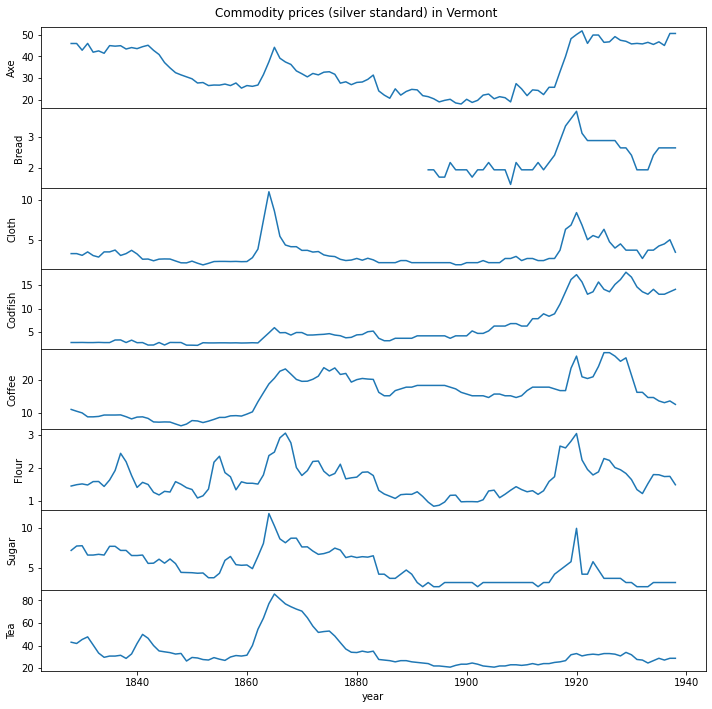

In [8]:
# build plot 
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(len(com_ls), hspace=0)
ax = gs.subplots(sharex=True)
fig.suptitle('Commodity prices (silver standard) in Vermont')

for count, com in enumerate(com_ls):
    df = df_v[df_v['Commodity'] == com]
    df = df.sort_values(by=["Item Year"])

    # values for plot title and axes
    commodity = df["Commodity"].unique()
    location = df["Location"].unique()
    first_year = df["Item Year"].iloc[0]
    last_year = df["Item Year"].iloc[-1]
    measure = df["Standard Measure"].unique()

    ax[count].plot(df["Item Year"], df["Standard Value"])
    ax[count].set(xlabel='year', ylabel=f'{commodity[0]}')


fig.tight_layout()
# Hide x labels and tick labels for all but bottom plot.
for x in ax:
    x.label_outer()

Above we can clearly see spikes in the data correlating to the Civil War (1861-1865) and World War 1 (1914-1918). 

We can also see some possible issues with the data that could throw off our measurements. Axes are initially expensive in the early 1800s, drop in price during the 1840s, and then peak again during the Civil War. In 1826 Collins and Company was founded in Connecticut and became the first American axe manufacturer. Before their founding axes were bought from local blacksmiths or imported from Europe. This likely caused the decline in axe prices during the early 1800s. Because of this, we'll be cutting off our analysis of axes to only include dates after 1850.

Flour seems to be a volitile commodity before the civil war. The first spike correlates to the Flour Riot of 1837, which was a response to the monetary policies of Andrew Jackson that drove the up price of flour and other goods and caused bank failures. Though the second spike int he 1850s has no clear historical cause, the cook stove and commercial baking soda were made available in that time frame and could contribute to a rise in demand for flour. In the 1880s, we see a general decline in flour prices. This is due to the invention of the roller mill, which replaced traditional stone mills.

The number of historic events concerning flour will make it difficult to accurately compare prices for each war. To compensate for this, we need to reevaluate the span of time our prices will be measured.

If we take a 20 year span before and after each war, we neatly avoid most historic fluctuations in price that are not due to the wars in question. We avoid the Flour Riot of 1837, the invention of rolling mills, and several other trends in the data that seem to segment around 1890. By taking a smaller time frame for comparison, we increase the likelyhood that the changes in commodity prices are only reflecting the effects of the wars, and not any other events or influences. 20 years should be a sufficient span to measure an average price, as well.

Below we will quickly truncate our data and regraph it, this time with the wars shaded.

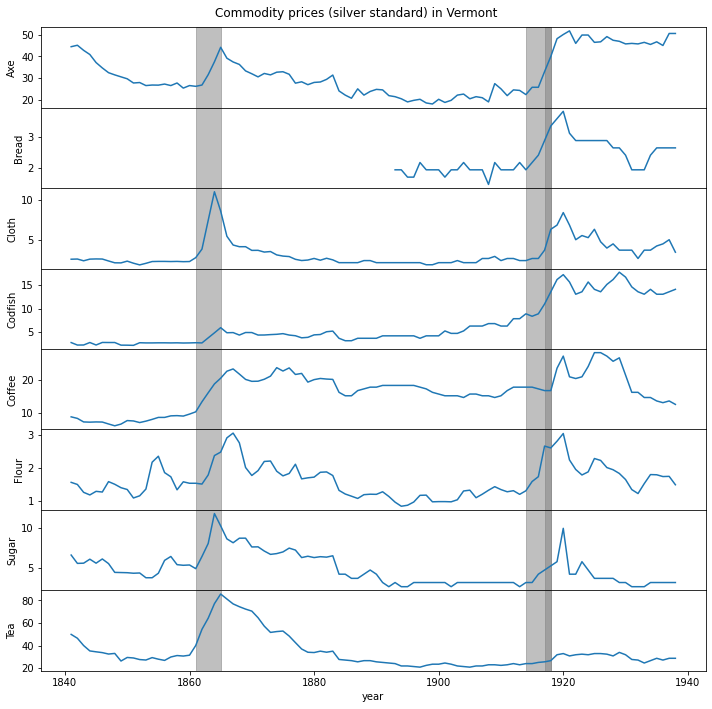

In [9]:
# Let's drop our unwanted data and check that our data has been formatted correctly
df_v = df_v.drop(df_v[(df_v['Item Year'] <= 1840) | (df_v['Item Year'] >= 1939)].index)

# build plot 
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(len(com_ls), hspace=0)
ax = gs.subplots(sharex=True)
fig.suptitle('Commodity prices (silver standard) in Vermont')

for count, com in enumerate(com_ls):
    df = df_v[df_v['Commodity'] == com]
    df = df.sort_values(by=["Item Year"])

    # values for plot title and axes
    commodity = df["Commodity"].unique()
    location = df["Location"].unique()
    first_year = df["Item Year"].iloc[0]
    last_year = df["Item Year"].iloc[-1]
    measure = df["Standard Measure"].unique()

    ax[count].plot(df["Item Year"], df["Standard Value"])
    ax[count].set(xlabel='year', ylabel=f'{commodity[0]}')
    ax[count].axvspan(1861, 1865, alpha=0.5, color='grey')
    ax[count].axvspan(1914, 1918, alpha=0.5, color='grey')
    ax[count].axvspan(1917, 1918, alpha=0.5, color='grey')


fig.tight_layout()
# Hide x labels and tick labels for all but bottom plot.
for x in ax:
    x.label_outer()

In the graph above, the Civil War (1861-1865) and WW1 (1914-1918) have been shaded, with the US's participation in WW1 (1917-1918) darkened.

Now that the wars are shaded we immediately see that virtually all commodities rise in price during wartime, but the peaks are often after the war has ended, especially for WW1. This warrants a reevaluation of the the measurements we plan to take.

Directly after the Civil War the US began the Second Industrial Revolution, so we can compare that time period from before the war. Commidities before, during, and after the Civil War follow the expected behavior of rising during the war and falling shortly thereafter, so we will still measure the rise in prices of commodities compared from before the war to during the war.

However, around WW1 most commodities steadily rise in price and peak during the Roaring Twenties, and during the US's participation during the war little visible change in the trend is observed, except perhaps in cloth and flour. This suggests that the economic forces that drove price change were independent from the US's participation in the war, and may not lend themselves to a fair comparison against the Civil War.

The questions asked of this dataset are confused by the close relationship between WW1 and the Roaring Twenties. The war time spending of Europe during WW1 proved to be a massive economic boom to the United States and occurs simultaneously as the wartime spending of the US government ramps up during 1917 and 1918 [6]. So, how do we compare the Civil War, which is isolated to a single nation and occurs just before the Second Industrial Revolution, to World War 1, a war that spanned the globe and devastated Europe while providing huge economic boons to the US? 

Comparing the rise and fall of prices between the Civil War and WW1 ignores the impact of the relationship between the US and Europe during WW1 and the Roaring Twenties. So we will expand our comparison and measure the Roaring Twenties as a separate affect on commodity prices. We will also isolate the participation of the US in WW1 from the greater conflict and measure both.

### Reevaluating the Question

Now that our graph has given preliminary answers to our questions, let's reevaluate them for the new time periods we will be analyzing.

* During the Civil War, by what percentage did commodities rise compared to the previous 20 year average?
* During World War 1, by what percentage did commodities rise compared to the previous 20 year average?
* During the Roaring Twenties, by what percentage did commodities rise compared to the 20 year average before WW1?
* During the US's participation of WW1, how did the rate of change of commodity prices change once the US entered WW1?
* For all the questions above:
    * When and what was the commodity peak?
    * If a commodity stayed stable, is there a historic reason?
    * Do the prices recover to normal after each historic event?
* Which commodities were most affected be each historic event?
* How did the effects compare across each historic event? For example, was cloth more affected by the Civil War or World War 1?
* How volatile were the prices before/during/after each war?

### Measuring Means

Let's measure the average prices of each commodityfor our selected time periods. We will also measure the ratio of the prices so that the different commodities can be compared with each other.

The Civil War lasted from 1861 to 1865, while World War 1 lasted from 1914 to 1918, however the the United States entered the war in 1917. The Roaring Twenties are generally considered to have lasted from 1920 to 1929. We'll be ignoring the time between 1918 and 1920 when the Spanish Flu was sweeping the globe.

In [10]:
# Let's create a new dataframe for our averages.

com_ls = ['Axe', 'Bread', 'Cloth', 'Codfish', 'Coffee', 'Flour', 'Sugar', 'Tea']
column_mn = ['Commodity', '1841-1860', 'Civil War', '1893-1913', 'WW1', 'USWW1', 'R. Twenties']
event_yrs = {'1841-1860': [1841, 1860], 'Civil War': [1861, 1865], '1893-1913': [1893, 1913], 'WW1': [1914, 1918], 'USWW1': [1917, 1918], 'R. Twenties': [1920, 1929]}

df_mn = pd.DataFrame(columns=column_mn)
df_mn['Commodity'] = com_ls

In [14]:
for com in com_ls:
    for event in event_yrs.items():
        mn = df_v[(df_v["Commodity"] == com) & (df_v["Item Year"] >= event[1][0]) & (df_v["Item Year"] <= event[1][1])]["Standard Value"].mean()
        df_mn.loc[df_mn.Commodity == com, event[0]] = mn
        
df_mn.head(8)

,Commodity,1841-1860,Civil War,1893-1913,WW1,USWW1,R. Twenties
0,Axe,31.8994,33.226,21.2274,29.3495,36.4464,48.3786
1,Bread,NaN,NaN,1.9131,2.55004,3.12741,2.95901
2,Cloth,2.27747,6.73155,2.25506,3.52541,4.99872,5.41967
3,Codfish,2.554,3.97634,5.40293,10.1436,12.2873,15.2154
4,Coffee,7.84626,15.7912,16.3831,17.2545,16.7317,24.9406
5,Flour,1.50065,1.93763,1.12472,1.98,2.63892,2.12183
6,Sugar,5.14179,8.27027,3.03759,4.07834,4.96721,4.65349
7,Tea,32.6459,64.3448,22.6077,25.0975,26.1432,32.313


### Measuring Ratios

Now that we have the mean commodity price for our time periods, let's find the ratios.

In [16]:
# Let's create a new dataframe for our averages.

df_ratio = pd.DataFrame()
df_ratio['Commodity'] = com_ls
df_ratio['Civil War'] = df_mn['Civil War'] / df_mn['1841-1860']
df_ratio['WW1'] = df_mn['WW1'] / df_mn['1893-1913']
df_ratio['R. Twenties'] = df_mn['R. Twenties'] / df_mn['1893-1913']

df_ratio.head(8)

,Commodity,Civil War,WW1,R. Twenties
0,Axe,1.04159,1.38262,2.27906
1,Bread,NaN,1.33293,1.54671
2,Cloth,2.95571,1.56333,2.40333
3,Codfish,1.55691,1.87742,2.81613
4,Coffee,2.01257,1.05319,1.52234
5,Flour,1.29119,1.76043,1.88654
6,Sugar,1.60844,1.34262,1.53197
7,Tea,1.97099,1.11013,1.4293


Now that we have our percentage data, let's list the commodities by the largest and smallest percentage change.

In [28]:
df_ratio.sort_values('Civil War', ascending=False).drop(['WW1', 'R. Twenties'], axis=1)

,Commodity,Civil War
2,Cloth,2.95571
4,Coffee,2.01257
7,Tea,1.97099
6,Sugar,1.60844
3,Codfish,1.55691
5,Flour,1.29119
0,Axe,1.04159
1,Bread,NaN


In [31]:
df_ratio.sort_values('WW1', ascending=False).drop(['Civil War', 'R. Twenties'], axis=1)

,Commodity,WW1
3,Codfish,1.87742
5,Flour,1.76043
2,Cloth,1.56333
0,Axe,1.38262
6,Sugar,1.34262
1,Bread,1.33293
7,Tea,1.11013
4,Coffee,1.05319


In [32]:
df_ratio.sort_values('R. Twenties', ascending=False).drop(['Civil War', 'WW1'], axis=1)

,Commodity,R. Twenties
3,Codfish,2.81613
2,Cloth,2.40333
0,Axe,2.27906
5,Flour,1.88654
1,Bread,1.54671
6,Sugar,1.53197
4,Coffee,1.52234
7,Tea,1.4293


Sources
1. https://www.valleytable.com/vt-article/short-history-wheat
2. https://en.wikipedia.org/wiki/Flour_riot_of_1837
3. https://connecticuthistory.org/world-renowned-maker-of-axes-the-collins-company-of-canton/
4. https://en.wikipedia.org/wiki/Oahu_sugar_strike_of_1920
5. https://eh.net/eha/
6. https://eh.net/encyclopedia/u-s-economy-in-world-war-i/
7. https://en.wikipedia.org/wiki/Industrial_Revolution_in_the_United_States
8. https://en.wikipedia.org/wiki/Roaring_Twenties


## Appendix A

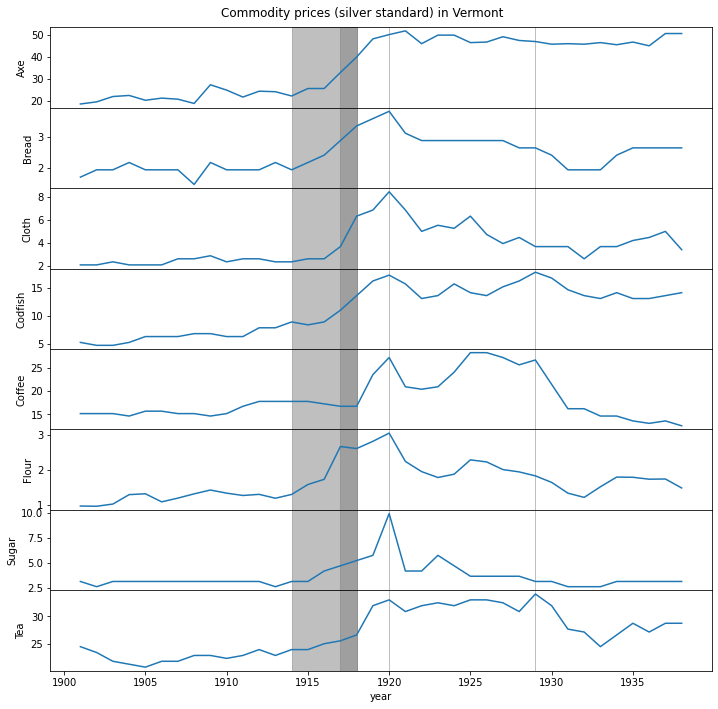

In [13]:
# Let's drop our unwanted data and check that our data has been formatted correctly
df_twen = df_v.drop(df_v[(df_v['Item Year'] <= 1900) | (df_v['Item Year'] >= 1939)].index)

# build plot 
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(len(com_ls), hspace=0)
ax = gs.subplots(sharex=True)
fig.suptitle('Commodity prices (silver standard) in Vermont')

for count, com in enumerate(com_ls):
    df = df_twen[df_twen['Commodity'] == com]
    df = df.sort_values(by=["Item Year"])

    # values for plot title and axes
    commodity = df["Commodity"].unique()
    location = df["Location"].unique()
    first_year = df["Item Year"].iloc[0]
    last_year = df["Item Year"].iloc[-1]
    measure = df["Standard Measure"].unique()

    ax[count].plot(df["Item Year"], df["Standard Value"])
    ax[count].set(xlabel='year', ylabel=f'{commodity[0]}')
    ax[count].axvspan(1929, 1929, alpha=0.5, color='grey')
    ax[count].axvspan(1914, 1918, alpha=0.5, color='grey')
    ax[count].axvspan(1917, 1918, alpha=0.5, color='grey')
    ax[count].axvspan(1920, 1920, alpha=0.5, color='grey')


fig.tight_layout()
# Hide x labels and tick labels for all but bottom plot.
for x in ax:
    x.label_outer()